In [1]:
import numpy as np
# torch imports
import torch
# gamma function will be needed
from scipy.special import gamma as Gamma

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

### Needed funcs
---

In [3]:
def compute_U(alpha, beta, gamma, lambda_f):
    return gamma * alpha * np.sum(lambda_f * (beta + 1) / 
        (alpha * beta * lambda_f * (gamma + 1) + alpha * lambda_f * (gamma - 1) - 2 * beta ** 2 + 2)) 

def compute_V(alpha, beta, gamma, lambda_f, c_f):
    return np.sum(c_f * (2 * alpha * beta * lambda_f + (1 - beta) * (1-beta ** 2) ) / (alpha * lambda_f) /
        (alpha * beta * lambda_f * (gamma + 1) + alpha * lambda_f * (gamma - 1) - 2 * beta ** 2 + 2)) 

def loss_asymptotic_clean(alpha, beta, gamma, zeta, lambda_f, K=1.0):
    return K * Gamma(zeta + 1) * (2 * alpha / (1 - beta)) ** (-zeta) / \
        (1 - compute_U(alpha, beta, gamma, lambda_f))

def loss_asymptotic_noisy(alpha, beta, gamma, nu, lambda_f, c_f):
    return (gamma / 2 / nu) * compute_V(alpha, beta, gamma, lambda_f, c_f) * Gamma(2 - 1 / nu) \
            * (alpha / (1 - beta)) ** (-2 + 1 / nu) / \
                (1 - compute_U(alpha, beta, gamma, lambda_f)) ** 2 

def fit_line(values, left=10, right=1000, n_intervals = 3):
    step = (right - left) / n_intervals

    a_s, b_s = np.empty(n_intervals), np.empty(n_intervals)
    for i in range(n_intervals):
        x = np.linspace(left + i * step, left + (i + 1) * step).astype(int)
        y = values[x]
        a, b = np.polyfit(np.log(x), np.log(y), deg=1)
        a_s[i], b_s[i] = a, b

    return a_s.mean(), a_s.std(), b_s.mean(), b_s.std()

### Load curves
---

In [18]:
N = 3000
n_steps = 10000
lr, momentum = 1.2, 0.0
# dataset = 'mnist'
dataset = 'bike_sharing'
# dataset = 'sgemm_product'
modes = ['mlp', 'linearized', 'mean_field', 'gauss']
# exp dir
exp_root_dir = '../output'
exp_name = 'compare_4_regimes'

data_root = f'{exp_root_dir}/{exp_name}/N={N}/{dataset}/lr={lr}/momentum={momentum}'

In [19]:
loss_curves = torch.load(f'{data_root}/loss_curves_4_regimes.pth')
# load data
data = torch.load(f'{data_root}/data.pth')
# 
c_f, eigv = data['c_diag'].numpy(), data['eigv'].numpy()
# compute cumsum
c_cumsum = np.cumsum(c_f)
c_cumsum = (c_cumsum[-1] - c_cumsum) / c_cumsum[-1]

Fit NTK spectrum amsymptotic

In [20]:
nu_mean, nu_std, b_nu_mean, b_nu_std = fit_line(eigv, left=5, right=300, n_intervals=3)

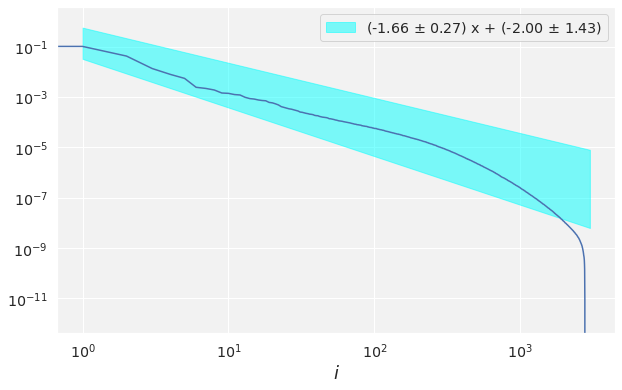

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(eigv);
ax.fill_between(
    np.arange(1, N + 1),
    np.exp(b_nu_mean - b_nu_std) * np.arange(1, N + 1) ** (nu_mean - nu_std),
    np.exp(b_nu_mean + b_nu_std) * np.arange(1, N + 1) ** (nu_mean + nu_std),
    color='cyan', alpha=0.5, 
    label=fr'({nu_mean:.2f} $\pm$ {nu_std:.2f}) x + ({b_nu_mean:.2f} $\pm$ {b_nu_std:.2f})'
)

ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$i$', fontsize=18);
ax.legend();

Fit err spectrum asymptotic

In [8]:
kappa_mean, kappa_std, b_kappa_mean, b_kappa_std = fit_line(c_cumsum, left=10, right=310, n_intervals=3)

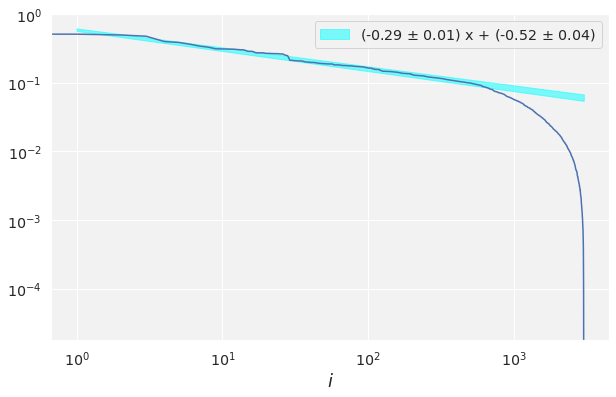

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(c_cumsum);
ax.fill_between(
    np.arange(1, N + 1),
    np.exp(b_kappa_mean - b_kappa_std) * np.arange(1, N + 1) ** (kappa_mean - kappa_std),
    np.exp(b_kappa_mean + b_kappa_std) * np.arange(1, N + 1) ** (kappa_mean + kappa_std),
    color='cyan', alpha=0.5, 
    label=fr'({kappa_mean:.2f} $\pm$ {kappa_std:.2f}) x + ({b_kappa_mean:.2f} $\pm$ {b_kappa_std:.2f})'
)

ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$i$', fontsize=18);
ax.legend();

Find const factor in asymptotic

In [10]:
from scipy.ndimage import gaussian_filter1d

In [11]:
# determine const
c_f_smooth = gaussian_filter1d(c_f, 10)
k_mean, k_std, b_k_mean, b_k_std  = fit_line(c_f_smooth, left=10, right=645, n_intervals=3)

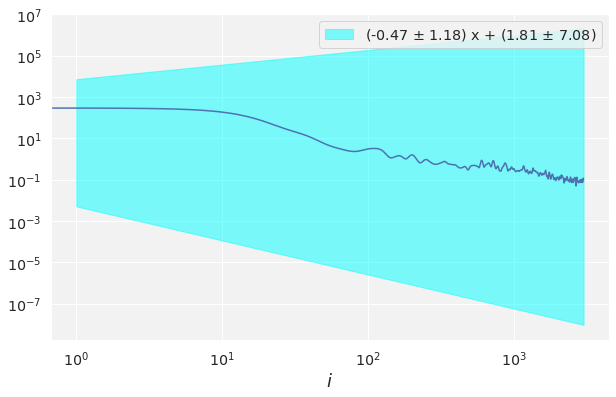

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(c_f_smooth);

ax.fill_between(
    np.arange(1, N + 1),
    np.exp(b_k_mean - b_k_std) * np.arange(1, N + 1) ** (k_mean - k_std),
    np.exp(b_k_mean + b_k_std) * np.arange(1, N + 1) ** (k_mean + k_std),
    color='cyan', alpha=0.5, 
    label=fr'({k_mean:.2f} $\pm$ {k_std:.2f}) x + ({b_k_mean:.2f} $\pm$ {b_k_std:.2f})'
)

ax.set_xscale('log');
ax.set_yscale('log');
ax.set_xlabel(r'$i$', fontsize=18);
ax.legend()

In [22]:
nu, kappa = nu_mean, kappa_mean
zeta = kappa / nu
# compute const in asymptotic
K = 2 * (-kappa) * np.exp(b_k_mean)

In [25]:
mode_caption = {
    'mlp' : 'NN', 
    'mean_field': r'SD $(\tau=+1)$',
    'gauss': r'SD $(\tau=-1)$',
    'linearized': 'linearized'
}

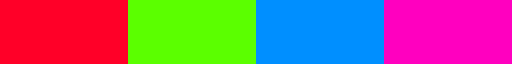

In [26]:
plt.cm.get_cmap('gist_rainbow', 4)

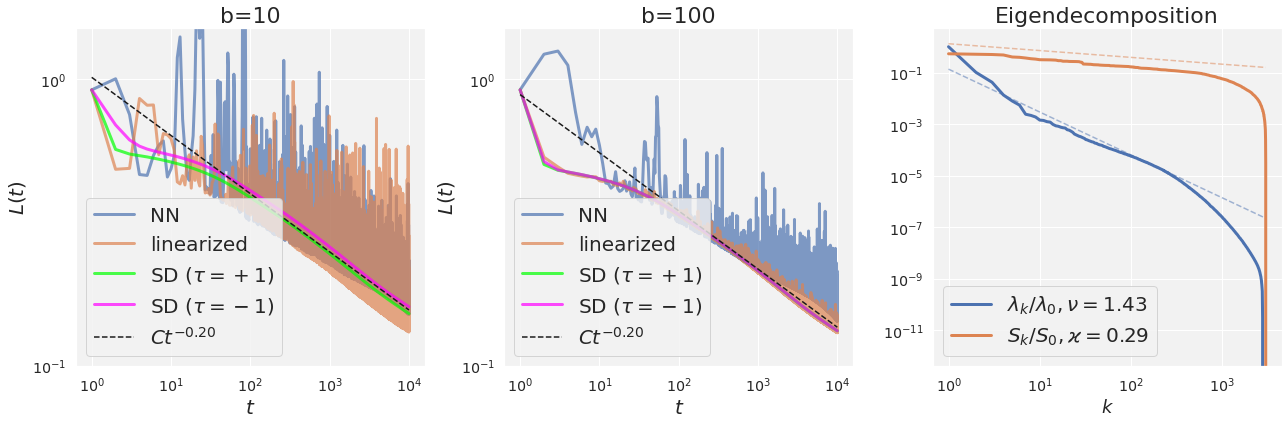

In [30]:
nrows, ncols = 1, len(loss_curves) + 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 6))

steps = np.arange(1, n_steps + 2)

colors = ['C0', 'C1', 'lime', 'magenta']

for i, (batch_size, alpha, beta) in enumerate(loss_curves):
    for j, mode in enumerate(modes):
        loss_curve = np.array(loss_curves[(batch_size, alpha, beta)][mode])
        ax[i].plot(steps, loss_curve, label=mode_caption[mode], color=colors[j], linewidth=3, alpha=0.7);

    gamma = (N - batch_size) / (N - 1) / batch_size
    # plot asymptotic
    loss_const = loss_asymptotic_clean(alpha, beta, gamma=gamma, zeta=zeta, lambda_f=eigv)
    ax[i].plot(steps, K * loss_const * (steps ** -zeta), color='k', linestyle='--', label=r'$C t^{-0.20}$');

    ax[i].legend(loc='lower left', fontsize=20);
    ax[i].set_xscale('log');
    ax[i].set_yscale('log');
    ax[i].set_yticks([1e-2, 1e-1, 1e+0]);
    ax[i].set_ylim(1e-1, 1.5);
    ax[i].set_xlabel(r'$t$', fontsize=20);
    ax[i].set_ylabel(r'$L(t)$', fontsize=20);
    ax[i].set_title(f'b={batch_size}', fontsize=22);

# plot spectrum
Ns = np.arange(1, N + 1)
ax[-1].plot(Ns, eigv, label=r'$\lambda_{k} / \lambda_{0}, \nu=1.43$', linewidth=3);
ax[-1].plot(
    Ns,
    np.exp(b_nu_mean) * np.arange(1, N + 1) ** (nu_mean),
    color='C0', alpha=0.5, linestyle='--'
)
ax[-1].plot(Ns, c_cumsum, label=r'$S_{k} / S_{0}, \varkappa=0.29$', linewidth=3);
ax[-1].plot(
    Ns,
    np.exp(b_kappa_mean) * np.arange(1, N + 1) ** (kappa_mean),
    color='C1', alpha=0.5, linestyle='--', 
)
# set scales
ax[-1].legend(fontsize=20);
ax[-1].set_xscale('log');
ax[-1].set_yscale('log');
ax[-1].set_xlabel(r'$k$', fontsize=18);
ax[-1].set_title('Eigendecomposition', fontsize=22);

fig.tight_layout()

plt.savefig(f'plots/compare_4_regimes/{dataset}/loss_curves_alpha={alpha}_beta={beta}.pdf')